## TODO::

* Paired T-test
* Wilcoxon signed-rank test
* Separate permutation testing into separate sheet. Use paired test as sub-function

# Permutation test

## Preamble
Definition
* $\vec{X}, \vec{Y}$ - random variables
* $H_0$ - relative order of $X$ and $Y$ is indistinguishable from random
* $F(\vec{X}, \vec{Y})$ - test statistic. Some function that depends on order, such as CORR or MI. For simplicity, define to be non-negative, s.t. $F > 0$ implies order.

Approximations:
* $\vec{Y}_{rand} \sim perm(\vec{Y})$ - need an assumption of the true distribution of random variables. Options are:
  - Define a distribution
  - Use permutations of original dataset
  - Use shifts of original dataset

Let
* $F_{true} = F(\vec{X}_{true}, \vec{Y}_{true})$
* $F_{rand} = F(\vec{X}_{rand}, \vec{Y}_{rand}) \Leftrightarrow F(\vec{X}_{true}, \vec{Y}_{rand})$
* $Z = F_{true} > F_{rand}$ - Event of observing a random order smaller than the true one
* $p = P[Z | H_0] = P[F_{true} > F_{rand} | H_0]$ : p-value, namely, probability of getting an event as unlikely or more unlikely under null hypothesis.


## Binomial Permutation Test
**Question**: How many permutation tests do we need to check if $p \leq p_0$, where, for example, $p_0 = 0.01$?

If we have $n$ permutation tests, and in $m$ of those tests $Z$ is false, then $\zeta = \sum_{i=1}^n (1 - Z_i)$ follows a binomial distribution
$$P[\zeta = m | H_0] = C^n_m p^m (1-p)^{m-n}$$
So the procedure is:
1. Do 1 permutation
2. Estimate confidence interval for $p$
3. If entire interval is below or above $p_0$, stop, otherwise repeat from 1.

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import ttest_1samp
from scipy.special import erf

corrAbs = lambda x, y: np.abs(np.corrcoef(x,y)[0,1])
perm = lambda x: x[np.random.permutation(x.size)]

# Compute mean value and confidence region of binomial distribution
def bin_conf(m, n, p0):
    return m/n, proportion_confint(m,n, alpha=p0, method='beta')

# Reports an upper bound on p-value for sample data
def chebyshev_sample_inequality(x, x0):
    #xaug = np.hstack((x, [x0]))  # For this test, all samples must come from the same set
    xaug = x
    n = len(xaug)
    t = (np.mean(xaug) - x0) / np.std(xaug)
    return 1 / (1 + t**2 * n/(n-1))


def chebyshev_sample_test(x, y, test_func, p0, nIter=100):
    fTrue = test_func(x, y)
    fPermLst = [test_func(x, perm(y)) for i in range(nIter)]
    pBound = chebyshev_sample_inequality(fPermLst, fTrue)
    z = (np.mean(fPermLst) - fTrue) / np.std(fPermLst)
    return pBound, pBound < p0, z
    
def paired_perm_test(x, y, test_func, p0, p0bin=0.01, maxIter=2000):
    fTrue = test_func(x, y)
    nPerm = 0
    zeta = 0
    while True:
        nPerm += 1
        z = fTrue > test_func(x, perm(y))
        zeta += 1 - int(z)
        pMu, pConf = bin_conf(zeta, nPerm, p0bin)
        if pConf[1] < p0:
            return pMu, True, nPerm
        elif pConf[0] > p0:
            return pMu, False, nPerm
        elif nPerm > maxIter:
            print("Warning, exceeded", maxIter, "operations. Concluding based on mean")
            return pMu, pMu < p0, nPerm

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


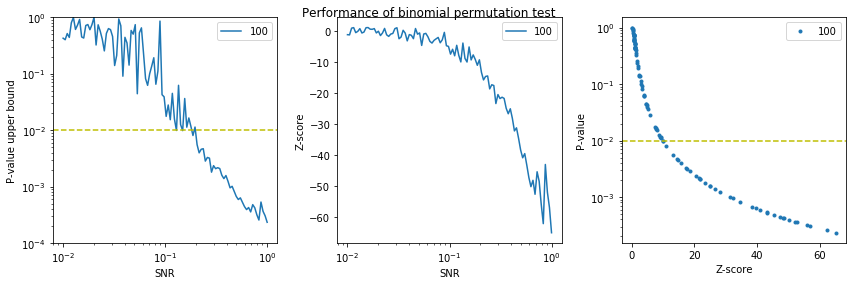

In [112]:
##########################
# Chebyshev Sample Test
##########################
nData = 1000
nSampleLst = [100]
pTHR = 0.01
alphaLst = 10 ** np.linspace(-2, 0, 100)

fig, ax = plt.subplots(ncols=3, figsize=(12,4), tight_layout=True)
fig.suptitle("Performance of binomial permutation test")

for nSample in nSampleLst:
    pBoundLst = []
    zScoreLst = []
    x = np.random.uniform(0, 1, nData)
    for alpha in alphaLst:
        y = alpha*x + (1 - alpha)*np.random.uniform(0, 1, nData)
        pBound, testRez, zscore = chebyshev_sample_test(x, y, corrAbs, pTHR, nIter=nSample)
        pBoundLst += [pBound]
        zScoreLst += [zscore]
        
    ax[0].loglog(alphaLst, pBoundLst, label=str(nSample))
    ax[0].set_ylim([1.0E-4, 1])
    ax[0].axhline(y=pTHR, linestyle='--', color='y')
    ax[1].semilogx(alphaLst, zScoreLst, label=str(nSample))
    ax[2].semilogy(np.abs(zScoreLst), pBoundLst, '.', label=str(nSample))
    ax[2].axhline(y=pTHR, linestyle='--', color='y')
    ax[0].set_xlabel("SNR")
    ax[0].set_ylabel("P-value upper bound")
    ax[1].set_xlabel("SNR")
    ax[1].set_ylabel("Z-score")
    ax[2].set_xlabel("Z-score")
    ax[2].set_ylabel("P-value")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

Warning, exceeded 2000 operations. Concluding based on mean
Warning, exceeded 2000 operations. Concluding based on mean
Warning, exceeded 2000 operations. Concluding based on mean
Warning, exceeded 2000 operations. Concluding based on mean
Warning, exceeded 2000 operations. Concluding based on mean
Warning, exceeded 2000 operations. Concluding based on mean


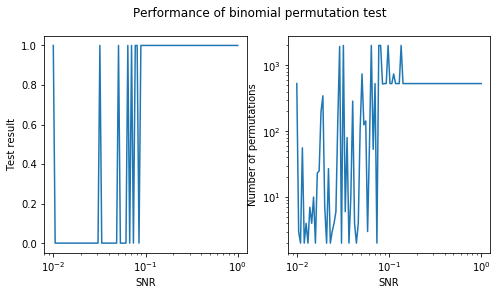

In [12]:
##########################
# Binomial Test
##########################
nData = 1000
alphaLst = 10 ** np.linspace(-2, 0, 100)
nPermLst = []
testRezLst = []

x = np.random.uniform(0, 1, nData)
for alpha in alphaLst:
    y = alpha*x + (1 - alpha)*np.random.uniform(0, 1, nData)
    pMu, testRez, nPerm = paired_perm_test(x, y, corrAbs, 0.01)
    nPermLst += [nPerm]
    testRezLst += [testRez]
    
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
fig.suptitle("Performance of binomial permutation test")
ax[0].semilogx(alphaLst, testRezLst)
ax[1].loglog(alphaLst, nPermLst)
ax[0].set_xlabel("SNR")
ax[0].set_ylabel("Test result")
ax[1].set_xlabel("SNR")
ax[1].set_ylabel("Number of permutations")
plt.show()    